# Video Generation via Diffusion Models

Within this notebook, we will implement basic video prediction and autoreggressive generation of videos, via diffusion models. This will follow the paper 'https://arxiv.org/pdf/2203.09481.pdf' will use a basic U-Net architecture to model the autoreggressive sequence of the video, which would be further corrected by utilizing a diffusion model to predict residual error within our approximation.

#### Basic Contents of the Paper
   * The forward process is just an autoreggressive model GRU U-net
   * The goal of the diffusion model is purely to correct the Autoreggressive GRU U-net.
   * From when we generate, we will input these corrections, to create to iteratively correct the time sequence model as we sample forward

In [54]:
import ResBlock_ConvGRU_Downsample
import UpSampleBlock
import MovingMNIST
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import MovingMNIST
import convgru
import torchvision
import Resblock

#### GRU U-Net

* Our first step is to create a model of a GRU U-net, this will allow us to do an autoregressive generation of our data. This should work fine to model a general idea of the videos flow; however, will fail to do anything much deeper

In [2]:
import torch.nn as nn

class AutoregressiveUNET(nn.Module):
    def __init__(self, channels = (1, 3, 6, 12, 48) ):
        super(AutoregressiveUNET, self).__init__()
        
        self.channels = channels
        self.Down = []
        self.Up = []
        
        in_channels = channels[0]
        
        for i in range( len(channels)-1):
            self.Down.append(ResBlock_ConvGRU_Downsample.ResBlock_ConvGRU_Downsample(channels[i], channels[i+1]))
        
        for i in range( len(channels)-1):
            self.Up.append(UpSampleBlock.ResBlockUpsample(channels[i+1], channels[i]))
        
                      
        self.DownSample = torch.nn.ModuleList(self.Down)
        self.UpSample = torch.nn.ModuleList(self.Up)
        
    def forward(self, x, hidden = None):
                      
        if hidden == None:
            hidden = [None]*len(self.channels)
        
        # CREATES THE NEW RESIDUAL AND HIDDEN WHICH WE WILL PASS
        h = [0]*len(self.channels)
        
        for i in range(len(self.channels)-1):
            x, h[i] = self.DownSample[i](x,hidden[i])
                      
        for i in reversed(range(len(self.channels)-1)):
            x = self.UpSample[i](x, h[i])
        
            
        return x, h
 

In [ ]:
AutoregressiveUNET()

# Data Loader

* We will be using the MovingMNIST dataset to try to train and test our data.

In [66]:
data_loader = MovingMNIST.MovingMNISTDataset('Data/mnist_test_seq.npy')

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
images = next(iter(data_loader))
import time


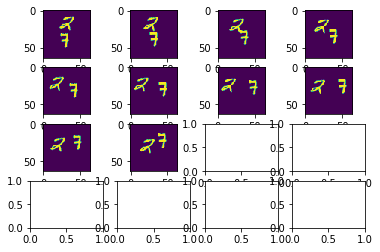

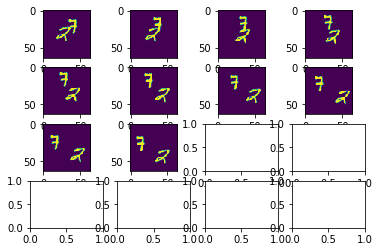

In [6]:
vid = np.array( np.array(images[0])[:, 0, : :] )
res = np.array( np.array(images[1])[:, 0, : :] )

fig, axs = plt.subplots(4,4)

for i in range(10):
    axs[int(i/4), i%4].imshow(vid[i, :, :])
    
fig, axs = plt.subplots(4,4)
for i in range(10):
    axs[int(i/4), i%4].imshow(res[i, :, :])

#### Training

Now that we have our model and our data we can train our model to attempt to predict the next frames of the video.

In [21]:
loss_fn = torch.nn.MSELoss() 
#state_dict = torch.load('./Models/MostRecent')
model = AutoregressiveUNET()
#model.load_state_dict(state_dict)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [22]:
torch.autograd.set_detect_anomaly(True)
import datetime

## PREDICTS THE NEXT 10 FRAMES OF A VIDEO GIVEN THE GROUND TRUTH
def predict(prev, pred):
    
    hidden = None
    output = None

    for image in prev:
            # forward compute the image
        hidden_prev = hidden
        output, hidden = model(image, hidden)
        
        
    results = torch.zeros_like(prev)
    results[0,: ,:, :, :] = output
        
    for i in range(9):
        results[i+1, :,:, :, :], hidden = model(pred[i, :,:, :, :], hidden)
        
    return results


def train_one_epoch(epoch_index):
    last_loss = 0.
    batch_size = 32
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    
    PREV = torch.zeros(10, batch_size, 1, 64, 64)
    PRED = torch.zeros(10, batch_size, 1, 64, 64)
    
    batch = 0
    
    for i, data in enumerate(data_loader):
        
        # given prev, predict pred
        if ( not (i % batch_size == batch_size-1)):
            print(i%batch_size, end = '\r')
            prev, pred = data
            PREV[:, i%batch_size, :, :, :] = prev
            PRED[:, i%batch_size, :, :, :] = pred
        else:
            prev, pred = data
            PREV[:, i%batch_size, :, :, :] = prev
            PRED[:, i%batch_size, :, :, :] = pred
            
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            
            # Make predictions for this batch
            results = predict(PREV, PRED)

            

            # Compute the loss and its gradients
            loss = loss_fn(PRED, results)
            print(loss)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            # RESEST THE BATCH
            PREV = torch.zeros(10, batch_size, 1, 64, 64)
            PRED = torch.zeros(10, batch_size, 1, 64, 64)
            
            
            # SAVE THE CURRENT MODEL
            if (batch % 25 == 0):
                torch.save(model.state_dict(), './Models/'+str(datetime.datetime.now().strftime("%B%d,%Y-%I")))
            batch+=1

    return last_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_one_epoch(epoch)

# GRU U-net Results

Initially, I had made the architecture too small to model the data accuratley as an attempt to run this on minimal computing resources. This will be redone once proper equipment for this task has been acquired.

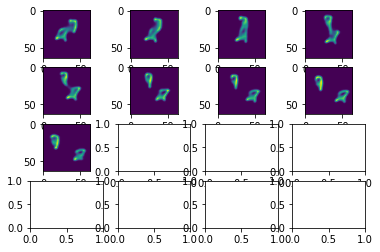

In [17]:
def predict_from_beginning(prev):
    
    hidden = None
    output = None

    for image in prev:
            # forward compute the image
        hidden_prev = hidden
        output, hidden = model(image, hidden)
        
        
    results = torch.zeros(20, prev.shape[1], prev.shape[2], prev.shape[3], prev.shape[4])
    results[0,: ,:, :, :] = output
        
    for i in range(19):
        results[i+1, :,:, :, :], hidden = model(results[i, :,:, :, :], hidden)
        
    return results

images = next(iter(data_loader))

pred = predict(torch.unsqueeze(images[0],1), torch.unsqueeze(images[1],1))

fig, axs = plt.subplots(4,4)
for i in range(9):
    axs[int(i/4), i%4].imshow(pred[i, 0,0 , :, :].detach().numpy())
    
    

    



# Construction of the Diffusion Model

We will now create the diffusion model. This model will take as input the difference between our U-Nets prediction, and the ground truth. The diffusion model will then model this, given the previous elements of the sequence (Modeled by our ConvGRU module).

#### Forward Diffusion

In forward diffusion we will progressively noise the image until it is comprised of no more than isotropic Guassian Noise. From here the model will learn to reconstruct data by reversing this noise. This will create a generative model mapping an isotropic Guassian image, into our datas image space.

In [77]:
import torch.nn.functional as F
import torchsummary
import matplotlib.pyplot as plt
import numpy as np

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        #transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))
    
    
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

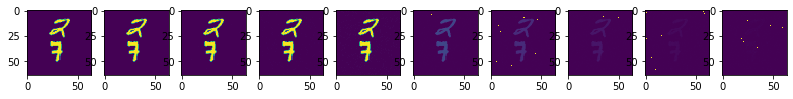

In [78]:
# FORWARD DIFFUSION
image = next(iter(data_loader))[0][0, :]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, (idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)
    

## Backwards process:

#### U-net

The backwards process is paramaterized by a U-net model, which aims to learn to reverse the noise which was added to the image.

In [59]:
from torch import nn
import math
import LinearAttn


class DownBlockGRU(nn.Module):

    def __init__(self, in_ch, out_ch):
        super().__init__()
        
        self.conv1 = Resblock.ResBlock(in_ch, out_ch)
        
        self.gru = convgru.ConvGRU(out_ch)
        
        self.transform = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x, h = None):
        
        #print (x.shape)
        
        x = self.conv1(x)
        
        #print(x.shape)
        
        h = self.gru(x, h)
        
        return self.transform(h), h
        
        
        
class DownBlock(nn.Module):
    
    
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        
        #print(in_ch, out_ch, time_emb_dim)
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        
        self.conv1 = Resblock.ResBlock(in_ch, out_ch)
        self.transform = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Resblock.ResBlock(2*out_ch, out_ch)
        self.relu = nn.ReLU()
        
        self.cross = LinearAttn.MultiHeadAttention(4, 16, out_ch)
        
        self.GRU_path = DownBlockGRU(in_ch, out_ch)
        
        self.t_dim = time_emb_dim
        self.in_ch = in_ch
        
        
    def forward(self, y, x_prev = None, t = None, h = None ):
        
        # THESE ARE USED TO TEST THE MODEL SUMMARY, THESE VALUES SHOULD ALWAYS BE ASSIGNED
        x_prev = torch.zeros_like(y) if x_prev is None else x_prev
        t = torch.zeros( (y.shape[0], self.t_dim) ) if t is None else t
        ##
        
        print(y.shape, x_prev.shape, t.shape)
        
        # CREATE TIME EMBED
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        
        # GRU Path to feed past information into system
        d, h = self.GRU_path(x_prev, h)
        
        print(y.shape, x_prev.shape, time_emb.shape)
        
        # First Conv
        y = self.conv1(y+time_emb[:, :self.in_ch, :, :])
        # Second Conv
        y = self.conv2(torch.concat([y+time_emb, h], axis = 1))
        
        res = self.cross(y) #FULLY CONNECTED LINEAR CROSS ATTENTION LAYER TAKES TOO MUCH RAM ON IMAGE DATA
        
        
        # Downward Outputs, Cross Residual, Next Hidden State 
        return self.transform(res), d, res, h


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


    
class UpBlock(nn.Module):
    
    
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        
        #print(in_ch, out_ch, time_emb_dim)
        
        self.time_mlp =  nn.Linear(time_emb_dim, in_ch)
        
        self.conv1 = Resblock.ResBlock(2*in_ch, out_ch)
        self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=2, stride=2)
        self.conv2 = Resblock.ResBlock(out_ch, out_ch)
        self.relu = nn.ReLU()
        
        self.cross = LinearAttn.MultiHeadAttention(4, 16, out_ch)
        
        self.t_dim = time_emb_dim
        self.in_ch = in_ch
        self.out_ch = out_ch

        
    def forward(self, y, res = None, t = None ):
        
        # THESE ARE USED TO TEST THE MODEL SUMMARY, THESE VALUES SHOULD ALWAYS BE ASSIGNED
        res = torch.zeros_like(y) if res is None else res
        t = torch.zeros( (y.shape[0], self.t_dim) ) if t is None else t
        ##
        
        # CREATE TIME EMBED
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        
        # First Conv
        y = self.conv1(torch.concat([y+time_emb, res], axis = 1))
        # Second Conv
        y = self.conv2(y+time_emb[:, :self.out_ch, :, :])
        
        y = self.cross(y) #FULLY CONNECTED LINEAR CROSS ATTENTION LAYER TAKES TOO MUCH RAM ON IMAGE DATA
        
        # RESULT
        return self.transform(y)


In [ ]:
torchsummary.summary( DownBlock(16, 32, 32), (16, 32, 32) ) 
torchsummary.summary( UpBlock(32, 16, 32), (32, 16, 16) ) 

In [63]:
class SimpleUnet(nn.Module):

    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (32, 64, 128, 256)
        up_channels = list(reversed( (32, 64, 128, 256) ))
        
        
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection|
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([DownBlock(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([UpBlock(up_channels[i], up_channels[i+1], \
                                        time_emb_dim) \
                    for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, y, x_prev=None, timestep=torch.Tensor([0]), hs_old = None ):
        
        hs_old = [None] * (len(self.downs)) if hs_old is None else hs_old
        
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        y = self.conv0(y)
        # Unet
        residual_inputs = []
        hs = []
        
        for down in self.downs:
            h=hs_old.pop(0)
            y, x_prev, res, h = down(y, x_prev, t, h)
            residual_inputs.append(res)
            hs.append(h)
            
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            
            #CROP THE RESIDUAL TO CENTER
            y = up(y, torchvision.transforms.functional.center_crop(residual_x, y.shape[2]), t)
            
            
        return self.output(y)

In [ ]:
torchsummary.summary( SimpleUnet(), (1, 32, 32) ) 

#### Residual

The image which we wish to learn is the the residual, which will then be corrected during the generative process

In [79]:
sigma = 255.

def get_res(x, x_pred):
    return (x - x_pred) / sigma

def correct_image(x_pred, y):
    return x + y * sigma

#### Training

From here, we can take our pretrained autoreggressive U-Net, and use its incorrect outputs to train our diffusion model. This is the same as the training of any image space diffusion model, just using the residuals we gathered from our predictions

In [80]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [81]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, i/stepsize+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Try more!

for epoch in range(epochs):
    
    batch_size = 32
    PREV = torch.zeros(10, batch_size, 1, 64, 64)
    PRED = torch.zeros(10, batch_size, 1, 64, 64)
    batch = 0
    
    
    # FOR THE ENTIRE DATA SET
    for i, data in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        # CONSTRUCT A BATCH
        if ( not (i % batch_size == batch_size-1)):
            print(i%batch_size, end = '\r')
            prev, pred = data
            PREV[:, i%batch_size, :, :, :] = prev
            PRED[:, i%batch_size, :, :, :] = pred
            continue
            
        prev, pred = data
        PREV[:, i%batch_size, :, :, :] = prev
        PRED[:, i%batch_size, :, :, :] = pred

        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        with torch.no_grad():
            results = predict(PREV, PRED) 
        
        # GETS THE DIFFERENCE BETWEEN THE NEXT 10 FRAMES, AND THE RESULTS
        residuals = get_res(pred, results)
        
        
        
        for i in range(residuals.shape(1)):
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
            loss = get_loss(model, residuals[:, i, :, :, :], t)

        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()
            

## RESULTS

Coming soon.